In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle

Difference between "green taxi" and "yellow taxi": Yellow Taxis pick up street-hailing passengers anywhere in NYC. Green Taxis pick up street-hailing passengers in NYC except for below East 96th Street and West 110th Street in Manhattan. The practical reality is that yellow taxis predominantly serve Manhattan, south of 96 St.

In [ ]:
path_zone = "/Users/yihanzhou/PycharmProjects/mlops-zoomcamp/01-intro/data/taxi_zone_lookup.csv"
df_zone = pd.read_csv(path_zone)

In [204]:
data_2401_path = "data/green_tripdata_2024-01.parquet"
data_2402_path = "data/green_tripdata_2024-02.parquet"

In [205]:
df = pd.read_parquet(data_2401_path)

In [206]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


Trip type: A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver.  
1= Street-hail 
2= Dispatch 

In [24]:
count_trip_type_1 = len(df[df['trip_type'] == 1.0])
count_trip_type_2 = len(df[df['trip_type'] == 2.0])
total = count_trip_type_2 + count_trip_type_1
print(f"{count_trip_type_1 / total* 100:.2f}%",f"{count_trip_type_2 / total* 100:.2f}%")

96.73% 3.27%


Most of the data in Jan 2024 is street hail.

## EDA

In [207]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

# df[df['trip_type'] == 1.0]['duration'].mean()
# df[df['trip_type'] == 2.0]['duration'].mean()

df['duration'] = df['duration'].apply(lambda x: x.total_seconds()/60)

# sns.distplot(df['duration'])

# len(df[df['duration']>200.0])/total *100
# only 0.4% of the ride is longer than 200

# or using quantile
# df['duration'].quantile(0.95)
# len(df[df['duration']>33.68])/total *100

# another way to see if the distplot is not clear
# df['duration'].describe()
# df['duration'].describe(percentiles=[0.95, 0.98, 0.99])
# sns.distplot(df[(df['duration'] > 1.0) & (df['duration'] < 60.0)]['duration'])

df_og = copy.deepcopy(df)
df = df[(df['duration'] > 1.0) & (df['duration'] < 60.0)]
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
# we will take a subset based on the duration

df[categorical] = df[categorical].astype(str)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54349 entries, 0 to 56550
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               54349 non-null  int32         
 1   lpep_pickup_datetime   54349 non-null  datetime64[us]
 2   lpep_dropoff_datetime  54349 non-null  datetime64[us]
 3   store_and_fwd_flag     51055 non-null  object        
 4   RatecodeID             51055 non-null  float64       
 5   PULocationID           54349 non-null  object        
 6   DOLocationID           54349 non-null  object        
 7   passenger_count        51055 non-null  float64       
 8   trip_distance          54349 non-null  float64       
 9   fare_amount            54349 non-null  float64       
 10  extra                  54349 non-null  float64       
 11  mta_tax                54349 non-null  float64       
 12  tip_amount             54349 non-null  float64       
 13  tolls_

/opt/anaconda3/envs/mlopszoomcamp/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Count'>

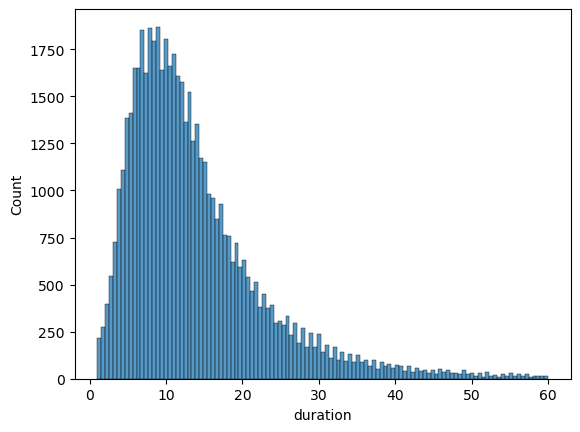

In [208]:
sns.histplot(df['duration'])

/opt/anaconda3/envs/mlopszoomcamp/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Density'>

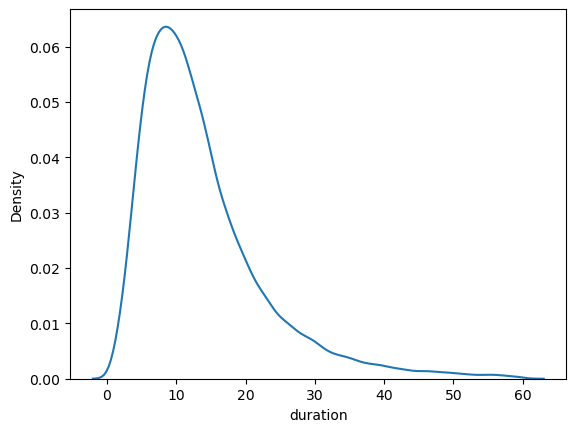

In [209]:
sns.kdeplot(df['duration'])

# Start training

In [ ]:
train_dicts = df[categorical+numerical].to_dict(orient="records")

dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)
# dv.feature_names_
# all the columns dict vectorizor uses for onehot encoding
# it didn't endcode trip distance as it's float
y_train = df['duration'].values

lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred = lr.predict(x_train)

# sns.distplot(y_pred, label="prediction")
# sns.distplot(y_train, label="label")
# plt.legend()

mean_squared_error(y_train,y_pred,squared=False) # sequence doesn't matter
# our model is wrong by 7.1 mins

In [165]:
def read_dataframe(path):
    df = pd.read_parquet(path)
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds()/60)
    df = df[(df['duration'] > 1.0) & (df['duration'] < 60.0)]
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [166]:
df_train = read_dataframe(data_2401_path)
df_val = read_dataframe(data_2402_path)

In [167]:
len(df_train),len(df_val)

(54349, 51468)

In [184]:
df_train['PU_DOLocationID'] = df_train['PULocationID']+"_"+df_train['DOLocationID']
df_val['PU_DOLocationID'] = df_val['PULocationID']+"_"+df_val['DOLocationID']

In [185]:
categorical = ['PULocationID','DOLocationID','PU_DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()
dv.feature_names_

train_dicts = df_train[categorical+numerical].to_dict(orient="records")
x_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient="records")
x_val = dv.transform(val_dicts)

In [186]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [191]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val,y_pred,squared=False) 

/opt/anaconda3/envs/mlopszoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.919781845355132

In [193]:
with open("model/lin_reg.bin",'wb') as file:
    pickle.dump((dv,lr), file)

In [194]:
lr = Lasso(alpha=0.001)
lr.fit(x_train,y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val,y_pred,squared=False) 

/opt/anaconda3/envs/mlopszoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.37083414447791

In [189]:
lr = Ridge(alpha=0.01)
lr.fit(x_train,y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val,y_pred,squared=False) 

/opt/anaconda3/envs/mlopszoomcamp/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.913648011158057